In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('chargeback_dataset.csv')

# view the dataset
df.head(10)

,Unnamed: 0,Card Number,Date,Amount,CBK
0,0,536518******2108,2015-05-01 00:01:54,36.54,No
1,1,536518******2108,2015-05-01 00:03:46,36.54,No
2,2,453211******1239,2015-05-01 00:08:50,69.00,No
3,3,548827******1705,2015-05-01 00:27:00,193.43,No
4,4,531681******9778,2015-05-01 01:32:46,132.00,No
5,5,515117******4107,2015-05-01 02:10:26,161.00,No
6,6,432032******9111,2015-05-01 08:09:15,110.00,No
7,7,544540******7141,2015-05-01 08:30:16,159.50,No
8,8,554906******0358,2015-05-01 09:13:51,126.50,Yes
9,9,554906******0358,2015-05-01 09:15:28,126.50,Yes


In [3]:
# Remove * from card numbers
df['Card Number'] = df['Card Number'].str.replace('*', '')

# Drop the serial numbers column
df.drop(df.columns[0], axis=1, inplace=True)

# Convert 'Yes' and 'No' class labels to 1 and 0 respectively
df['CBK'] = df['CBK'].map({'Yes': 1, 'No': 0})

<ipython-input-3-c62b374053f7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Card Number'] = df['Card Number'].str.replace('*', '')


In [4]:
# Convert date string to Pandas datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract the day of the week
df['day_of_week'] = df['Date'].dt.day_name()

In [5]:
# Preprocessing for day of the week by mapping each day to a number
df['day_of_week_in_num'] = df['day_of_week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})

# Creating 2 new features to capture information on day of the week
df['day_of_week_sin'] = np.sin(df['day_of_week_in_num'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week_in_num'] * (2 * np.pi / 7))

In [6]:
# Preprocessing for time of transaction

# Extract the earliest date
mindate = df['Date'].min()

# Create a new feature for time of transaction and drop the day column
df['Timestamp in Seconds'] = (df['Date'] - mindate).dt.total_seconds()
df.drop(columns=['Date'], inplace=True)

In [7]:
# Creating new features

# Calculate the average time difference between consecutive transactions for each unique Card Number
df['Card Frequency'] = df.groupby('Card Number')['Timestamp in Seconds'].transform(lambda x: x.diff().mean()).fillna(0)

# Calculate the average amount per transaction for each unique Card Number
df['AmountPerTransactionFrequency'] = df['Amount'] / df.groupby('Card Number')['Timestamp in Seconds'].transform('count')

df['TimeBetweenTransactions'] = df.groupby('Card Number')['Timestamp in Seconds'].diff().fillna(0)

# Calculate the average time per transaction for each card
df['AverageTimeBetweenTransaction'] = df.groupby('Card Number')['TimeBetweenTransactions'].transform('mean').fillna(0)

In [8]:
X = df[['Card Number', 'Amount', 'day_of_week_sin', 'day_of_week_cos', 'Timestamp in Seconds', 'Card Frequency', 'AmountPerTransactionFrequency', 'TimeBetweenTransactions', 'AverageTimeBetweenTransaction']]
y = df['CBK']

In [9]:
# split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
# Apply SMOTE-NC to the training data
smoteNC = SMOTENC(categorical_features = [0, 2, 3], random_state=42, sampling_strategy = 0.9)
X_train, y_train = smoteNC.fit_resample(X_train, y_train)

In [11]:
print(pd.Series(y_train).value_counts())

0    8440
1    7596
Name: CBK, dtype: int64


In [108]:
DTmodel = tree.DecisionTreeClassifier(random_state = 42)
DTmodel.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [109]:
y_pred = DTmodel.predict(X_test)

In [110]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(cnf_matrix)
print()
print('Classification Report')
print(classification_report(y_test, y_pred))

print('Accuracy: ',accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1 score: ', f1)
print('ROC AUC Curve: ', auc)

Confusion Matrix
[[2055   60]
 [  25   86]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2115
           1       0.59      0.77      0.67       111

    accuracy                           0.96      2226
   macro avg       0.79      0.87      0.82      2226
weighted avg       0.97      0.96      0.96      2226

Accuracy:  0.9618149146451033
Precision:  0.589041095890411
Recall:  0.7747747747747747
f1 score:  0.6692607003891051
ROC AUC Curve:  0.8732029902242668


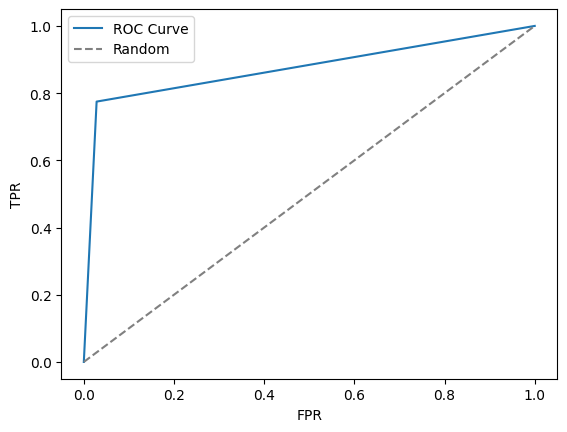

In [93]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1],[0,1], linestyle='--', label='Random', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [111]:
import json

params = json.dumps(DTmodel.get_params(), indent = 4)
print("Hyperparameters:")
print(params)

Hyperparameters:
{
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": null,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "splitter": "best"
}


In [112]:
# Get the decision tree's depth
tree_depth = DTmodel.tree_.max_depth
print(f"Tree Depth: {tree_depth}")

# Get the leaf indices for each sample
leaf_indices = DTmodel.apply(X)

# Calculate the number of unique leaf indices, which represents the number of leaf nodes
num_leaf_nodes = np.unique(leaf_indices).size
print(f"Number of Leaf Nodes: {num_leaf_nodes}")

Tree Depth: 23
Number of Leaf Nodes: 439


In [118]:
fnames = X.columns.tolist()
print(fnames)

['Card Number', 'Amount', 'day_of_week_sin', 'day_of_week_cos', 'Timestamp in Seconds', 'Card Frequency', 'AmountPerTransactionFrequency', 'TimeBetweenTransactions', 'AverageTimeBetweenTransaction']


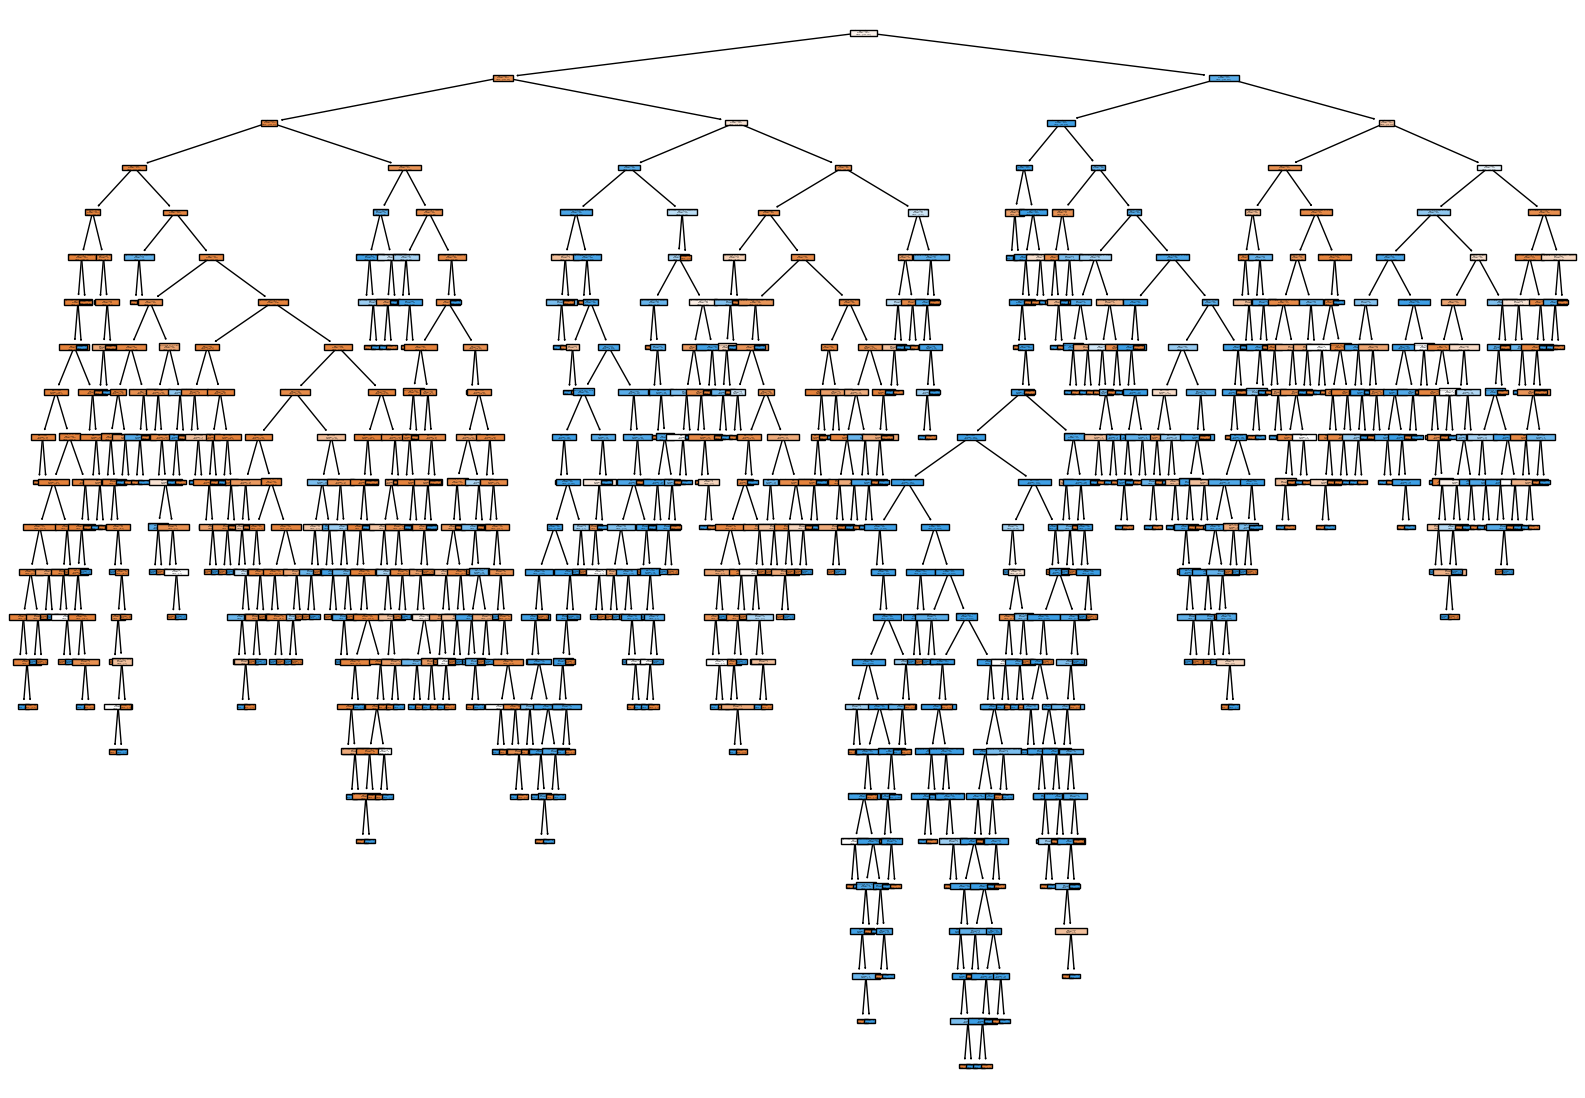

In [119]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,14))
plot_tree(DTmodel, filled = True, feature_names = fnames)
plt.show()